# Figures for the Tracking experiment results

First of all, let's reveiew what data do we have. we have:
- the Rigid Body Position: This is the real time of the change in movement being reported to Python
- the LED postion: this is when the actual movement happened, which is in the beginning of the trial
- trial number
- time


Here is a list of figures needed for demonstrating (and interpreting) the tracking experiment results:

#### For single session
- time vs. rigid body position for the whole experiment
- time vs. led position
- lines that mark beginning of the trial for the whole experiment
- Trial vs. latency
- Latency distribution

#### Comparing multiple sessions
- Latency distribution of Tracking for different parameters (FR, Exposure time, video type, etc.)

In [1]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import vrlatency as vrl

# %matplotlib tk

In [4]:
data_path = "../../data/"
figure_path = "../../figures/"

In [5]:
os.chdir(data_path)

In [8]:
filenames = []
for filename in glob.glob("*.csv"):
    if filename.split('_')[0] == 'tracking':
        print(filename)
        filenames.append(filename)

tracking_20181010_121538.csv
tracking_20181010_121719.csv
tracking_20181010_121942.csv
tracking_20181010_122129.csv
tracking_20181010_122259.csv


In [9]:
session_number = 0
filename = filenames[session_number]
session_name = filename.split('.')[0]
dfd = vrl.read_csv(filename)

In [10]:
dfd.head()

,Trial,Time,RigidBody_Position,LED_Position
0,2,4.636990,1.025364,L
1,2,4.637638,1.025364,L
2,2,4.638669,1.025364,L
3,2,4.639693,1.025364,L
4,2,4.640636,1.025366,L


In [11]:
dfd_transformed = vrl.analysis.transform_tracking_df(dfd, session=session_name)

In [12]:
dfd_transformed.head()

,Session,Trial,Sample,Time,RigidBody_Position,RigidBody_Position_norm,LED_Position,LED_State,TrackingLatency
0,tracking_20181010_121538,2,0,0.000000,1.025364,-0.006917,L,0.007067,6.649078
1,tracking_20181010_121538,2,1,0.647782,1.025364,-0.006917,L,0.007067,6.649078
2,tracking_20181010_121538,2,2,1.678644,1.025364,-0.006917,L,0.007067,6.649078
3,tracking_20181010_121538,2,3,2.702897,1.025364,-0.006917,L,0.007067,6.649078
4,tracking_20181010_121538,2,4,3.645726,1.025366,-0.006916,L,0.007067,6.649078


---

In [13]:
plt.rcParams.update({'font.size': 20})

## Rigid body position in time, with lines showing the trial onset

Let's select several trials for visualization

In [15]:
dd = dfd_transformed.loc[dfd_transformed['Trial'] < 10]

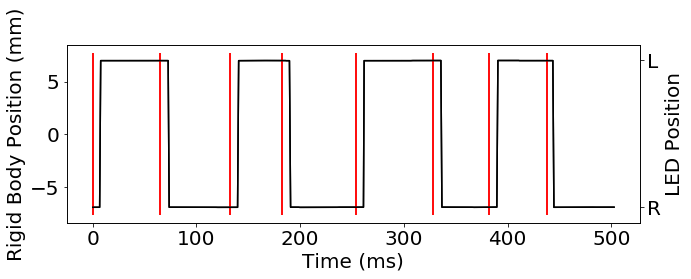

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
# vrl.analysis.plot_rb_position(dd['Time'], dd['RigidBody_Position_norm'], ax=ax);
ax.plot(dd['Time'], dd['RigidBody_Position_norm'] * 1000, color='k')
trial_init_time = dd.groupby('Trial').Time.apply(lambda x: x.min()).values
vrl.analysis.plot_trial_init(trial_init_time, ax=ax)
ax.set(xlabel='Time (ms)', ylabel='Rigid Body Position (mm)');

ax2 = ax.twinx()
ax2.plot(dd['Time'], dd['RigidBody_Position_norm'] * 1000, color='k')
trial_init_time = dd.groupby('Trial').Time.apply(lambda x: x.min()).values
vrl.analysis.plot_trial_init(trial_init_time, ax=ax2)
plt.yticks([dd['RigidBody_Position_norm'].min() * 1000, dd['RigidBody_Position_norm'].max() * 1000], ['R', 'L'])
ax2.set(ylabel='LED Position');
fig.tight_layout()

# plt.savefig(figure_path + 'tracking_a' + '_session' + str(session_number) + '.png', transparent=False)

## Trials versus latency (with distribution)

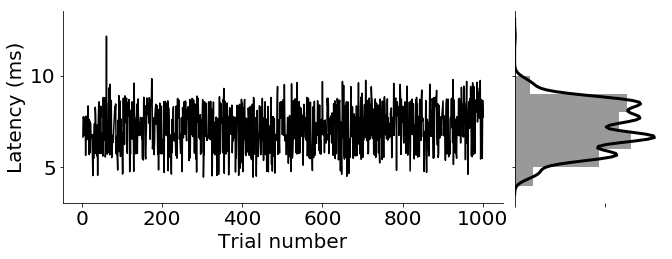

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
vrl.analysis.plot_tracking_latency_over_session(dfd_transformed.Trial, dfd_transformed.TrackingLatency, ax=ax1)
ax1.set(xlabel='Trial number', ylabel='Latency (ms)')
sns.despine(top=True, ax=ax1)

vrl.analysis.plot_tracking_latency_distribution(dfd_transformed['TrackingLatency'].unique(), ax=ax2)
sns.despine(top=True, bottom=True, ax=ax2)
ax2.set(xticklabels='')
fig.tight_layout(w_pad=0)

# plt.savefig(figure_path + 'tracking_b' + '_session' + str(session_number) + '.png', transparent=False)

## Latency distribution alone

Enables comparison between different tracking latency measurements

In [27]:
latencies = dfd_transformed['TrackingLatency'].unique()

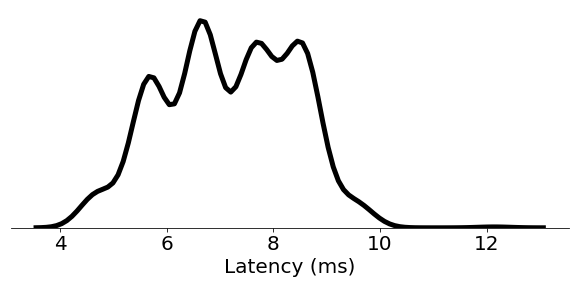

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.despine(left=True)

data = latencies[np.isnan(latencies) == False]
sns.distplot(data, hist=False, color="k", kde_kws={"linewidth": 5, "alpha": 1}, ax=ax);
# ax.set(xlabel='Latency (ms)', ylabel='Frequency (normalized)');
ax.set(xlabel='Latency (ms)', ylabel='');
plt.yticks([]);

---

## Comparing multiple latency measurements data

- Read the data for all the (selected) experiments and put them in a single dataframe
- Read the parameters fora ll the (selected) experiments and put them in a single dataframe
- merge the data dataframe and the paramters dataframe
- then we are set

### Read several data and save the latency dataframe

In [54]:
dfl_all = pd.DataFrame()

for filename in filenames:
    print(filename)

    dfd = vrl.read_csv(filename)
    dfd['Time'] *= 1000
    dfd['Session'] = filename.split('.')[0]
    dfl = vrl.get_tracking_latencies(dfd).to_frame().reset_index()
    df = pd.merge(dfd, dfl, on='Trial')
    
    dfl_all = dfl_all.append(df)

tracking_20181010_121538.csv
tracking_20181010_121719.csv
tracking_20181010_121942.csv
tracking_20181010_122129.csv
tracking_20181010_122259.csv


In [56]:
params = {'Session': [filename.split('.')[0] for filename in filenames], 
          'TrackingRate': [240, 240, 120, 60, 30], 
          'ExposureTime': [0.5, 1.0, 0.5, 0.5, 0.5],
          'TrackingAlgorithm': [1, 1, 1, 1, 1],
          'VideoType': ['Object Mode', 'Object Mode', 'Object Mode', 'Object Mode', 'Object Mode']}

In [59]:
dfp_all = pd.DataFrame(params)
dfp_all.head()

,Session,TrackingRate,ExposureTime,TrackingAlgorithm,VideoType
0,tracking_20181010_121538,240,0.5,1,Object Mode
1,tracking_20181010_121719,240,1.0,1,Object Mode
2,tracking_20181010_121942,120,0.5,1,Object Mode
3,tracking_20181010_122129,60,0.5,1,Object Mode
4,tracking_20181010_122259,30,0.5,1,Object Mode


In [62]:
df_all = pd.merge(dfl_all, dfp_all, on='Session')

df_all = df_all[['Session', 'Trial', 'TrackingRate', 'ExposureTime', 'TrackingAlgorithm', 'VideoType', 'TrackingLatency']]
df_all.drop_duplicates(inplace=True)

In [64]:
df_all.head()

,Session,Trial,TrackingRate,ExposureTime,TrackingAlgorithm,VideoType,TrackingLatency
0,tracking_20181010_121538,2,240,0.5,1,Object Mode,6.649078
65,tracking_20181010_121538,3,240,0.5,1,Object Mode,7.750848
132,tracking_20181010_121538,4,240,0.5,1,Object Mode,7.692560
183,tracking_20181010_121538,5,240,0.5,1,Object Mode,6.716680
253,tracking_20181010_121538,6,240,0.5,1,Object Mode,7.190499


## Latency distribution for different session

30
60
120
240


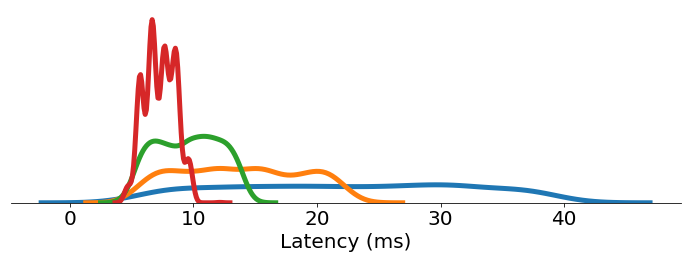

In [65]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.despine(left=True)

for name, dd in df_all.groupby('TrackingRate'):
    print(name)
    sns.distplot(dd.TrackingLatency.values, hist=False, kde_kws={"linewidth": 5, "alpha": 1}, ax=ax)
    
ax.set(xlabel='Latency (ms)', ylabel='');
plt.yticks([]);
fig.tight_layout()


tracking_20181003_192844.csv
tracking_20181003_193319.csv
tracking_20181005_165731.csv
tracking_20181005_171454.csv
tracking_20181005_171821.csv
tracking_20181005_172311.csv
tracking_20181005_173035.csv


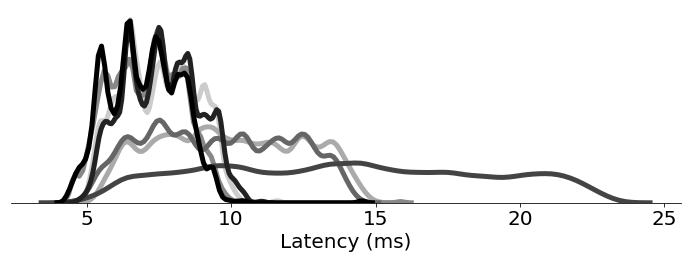

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.despine(left=True)

compare_these = filenames
gs_color = np.linspace(.8, 0, len(compare_these))

for ind, filename in enumerate(compare_these):
    print(filename)
    dfd = vrl.read_csv(filename)
    dfd_transformed = vrl.analysis.transform_tracking_df(dfd, session=session_name)
    latencies = dfd_transformed['TrackingLatency'].values
    data = latencies[np.isnan(latencies) == False]
    sns.distplot(data, color=str(gs_color[ind]), hist=False, kde_kws={"linewidth": 5, "alpha": 1}, ax=ax)
    
ax.set(xlabel='Latency (ms)', ylabel='')
plt.yticks([]);
fig.tight_layout()

plt.savefig(figure_path + 'tracking_c' + '_session' + str(session_number) + '.png', transparent=False)